#### Reference: https://www.tensorflow.org/text/tutorials/classify_text_with_bert

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [2]:
print("Tensorflow version:", tf.__version__)
print("Hub version:", hub.__version__)
print("text version:", text.__version__)

Tensorflow version: 2.8.0
Hub version: 0.12.0
text version: 2.8.2


### 1. Download dataset

In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

train_dir = os.path.join(dataset_dir,'train')


# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

- Note: When using the validation_split and subset arguments, make sure to either specify a random seed, or to pass shuffle=False, so that the validation and training splits have no overlap.

- 可以簡單的使用 AUTOTUNE 找到 prefetching 的最佳參數：

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed  =42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
            'aclImdb/train',
             batch_size = batch_size,
             validation_split = 0.2,
             subset = 'training',
             seed =seed)

class_names = raw_train_ds.class_names

train_ds = raw_train_ds.cache().prefetch(buffer_size = AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
        'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [5]:
### Check data example

for text_batch,label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')
    

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

## 2. Load model from tensorlow hub

- Choose a BERT model: https://tfhub.dev/google/collections/transformer_encoders_text/1


#### Model use in this example

- BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1

- Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3

In [6]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected                : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected     : {tfhub_handle_preprocess}')

BERT model selected                : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected     : https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### 2-1. BERT preprocessing

- Each BERT model has a unique preprocessing model

- Preprocessing output: (input_words_id, input_mask and input_type_ids)
- The input_type_ids only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

In [7]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [8]:
### preprocessing sample test

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


### 2-2. BERT model

- BERT output: (pooled_output, sequence_output, encoder_outputs)
- pooled_output represents each input sequence as a whole. The shape is [batch_size, H]. You can    think of this as an embedding for the entire movie review. >>> [CLS]
- sequence_output represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the movie review.
- encoder_outputs are the intermediate activations of the L Transformer blocks. outputs["encoder_outputs"][i] is a Tensor of shape [batch_size, seq_length, 1024] with the outputs of the i-th Transformer block, for 0 <= i < L. The last value of the list is equal to sequence_output.

- For the fine-tuning you are going to use the pooled_output array.

In [9]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262903  0.99280983 -0.18611847  0.3667386   0.15233745  0.6550445
  0.9681154  -0.94862705  0.00216164 -0.9877732   0.0684273  -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946295  0.34321263  0.33231527 ...  0.2130087   0.71020836
  -0.05771071]
 [-0.2874208   0.31981027 -0.23018518 ...  0.5845508  -0.21329744
   0.7269212 ]
 [-0.66157013  0.6887687  -0.8743292  ...  0.10877226 -0.26173285
   0.47855547]
 ...
 [-0.22561097 -0.2892568  -0.07064426 ...  0.47566074  0.83277184
   0.40025318]
 [-0.29824227 -0.27473107 -0.05450526 ...  0.488498    1.0955358
   0.18163362]
 [-0.4437815   0.00930744  0.07223801 ...  0.17290124  1.1833242
   0.07898009]]


### 3. Define Model

- BERT output 取用[CLS]: ['pooled_output']


In [10]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape = (),dtype = tf.string,name = 'text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess,name=  'preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder,trainable = True,name = 'BERT-encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1,activation = None,name= 'classifier')(net)
    
    return tf.keras.Model(text_input,net)


    

#### Check the model pipeline

In [11]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.52456105]], shape=(1, 1), dtype=float32)


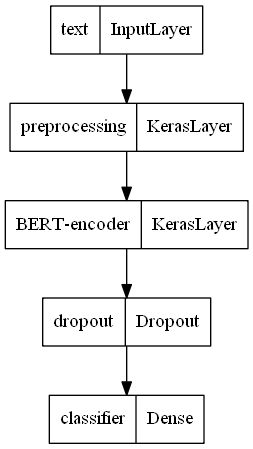

In [12]:
tf.keras.utils.plot_model(classifier_model)

### 4. Model training

- For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam)

- linear warm-up phase over the first 10% of training steps (num_warmup_steps)
- In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [13]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=  True)
metrics = tf.metrics.BinaryAccuracy()



In [14]:
epochs= 5


steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch*epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr,
                                         num_train_steps = num_train_steps,
                                         num_warmup_steps = num_warmup_steps,
                                         optimizer_type = 'adamw')



In [15]:
classifier_model.compile(optimizer= optimizer,
                        loss = loss,
                        metrics = metrics)

print(f'Training model with {tfhub_handle_encoder}')

history = classifier_model.fit(x = train_ds,
                              validation_data = val_ds,
                              epochs = epochs)


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 137s 211ms/step - loss: 0.4896 - binary_accuracy: 0.7408 - val_loss: 0.3847 - val_binary_accuracy: 0.8372
Epoch 2/5
625/625 [==============================] - 129s 206ms/step - loss: 0.3302 - binary_accuracy: 0.8540 - val_loss: 0.3589 - val_binary_accuracy: 0.8436
Epoch 3/5
625/625 [==============================] - 129s 206ms/step - loss: 0.2524 - binary_accuracy: 0.8921 - val_loss: 0.3864 - val_binary_accuracy: 0.8490
Epoch 4/5
625/625 [==============================] - 129s 207ms/step - loss: 0.1918 - binary_accuracy: 0.9251 - val_loss: 0.4461 - val_binary_accuracy: 0.8506
Epoch 5/5
625/625 [==============================] - 129s 207ms/step - loss: 0.1514 - binary_accuracy: 0.9434 - val_loss: 0.4854 - val_binary_accuracy: 0.8546


### 5. Evaluation

In [17]:
loss,accuracy = classifier_model.evaluate(test_ds)

print(f'Loss:{loss}')
print(f'Accuracy: {accuracy}')


782/782 [==============================] - 86s 109ms/step - loss: 0.4645 - binary_accuracy: 0.8570
Loss:0.46446695923805237
Accuracy: 0.8570399880409241


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


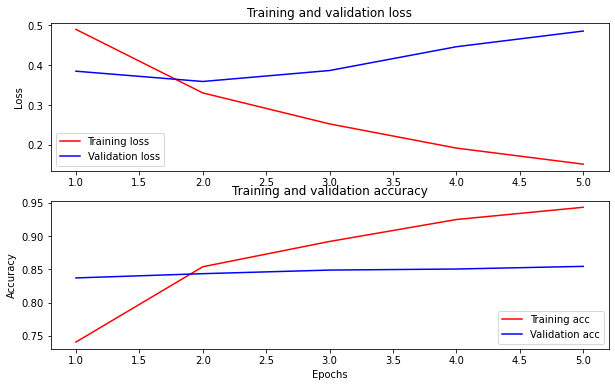

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)
fig = plt.figure(figsize = (10,6))
fig.tight_layout()


plt.subplot(2,1,1)
plt.plot(epochs,loss,'r',label = 'Training loss')
plt.plot(epochs, val_loss,'b',label = 'Validation loss')
plt.title('Training and validation loss')

plt.ylabel('Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(epochs,acc,'r',label = 'Training acc')
plt.plot(epochs,val_acc,'b',label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=  'lower right')


### 6. Save model

- include_optimizer = False: 優化器的狀態不會被保存下來，可以節省不少體積

In [22]:
dataset_name = 'imdb'
save_model_path = './{}_bert'.format(dataset_name.replace('/','_'))
classifier_model.save(save_model_path,include_optimizer = False)

### 7. Load model and predict

In [23]:
reloaded_model = tf.saved_model.load(save_model_path)

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)
    

Results from the saved model:
input: this is such an amazing movie! : score: 0.998837
input: The movie was great!           : score: 0.994725
input: The movie was meh.             : score: 0.958421
input: The movie was okish.           : score: 0.026961
input: The movie was terrible...      : score: 0.001273

Results from the model in memory:
input: this is such an amazing movie! : score: 0.998837
input: The movie was great!           : score: 0.994725
input: The movie was meh.             : score: 0.958421
input: The movie was okish.           : score: 0.026961
input: The movie was terrible...      : score: 0.001273

